In [2]:
import sys, os, io, json, numpy as np, random, time
#from sklearn.metrics import roc_auc_score
import xgboost as xgb
import tensorflow as tf
from importlib import reload
import split
reload(split)
from split import split_graph, split_interface, make_split, make_split_quick, make_gax, split_quick_graph, split_quick_graph_transpose
import graphviz
from sklearn import metrics
import cProfile


def profile(func):
    """Decorator for run function profile"""
    def wrapper(*args, **kwargs):
        profile_filename = func.__name__ + '.prof'
        profiler = cProfile.Profile()
        result = profiler.runcall(func, *args, **kwargs)
        profiler.dump_stats(profile_filename)
        return result
    return wrapper

In [3]:
pool = np.load('../prepare_dataset/pool_00.npz')
features_bool, f_time, label_orig = (pool[name] for name in ['features', 'f_time', 'label'])
label = label_orig

In [165]:
np.random.seed(42)
features_orig = np.random.normal(loc=features_bool*1.0, scale=0.01)
#features = features[:150000,:]; label = label_orig[:150000, :]
features_swap = np.concatenate([features[:,7:8], features[:,1:7], features[:,0:1], features[:,8:]], axis=1)

In [166]:
f_test, l_test = features_orig[150000:,:], label_orig[150000:, :]
features = features_orig[:150000,:]; label = label_orig[:150000, :]

In [167]:
%%time
make_split(np.zeros(label.shape), features, label)

CPU times: user 158 ms, sys: 40.5 ms, total: 199 ms
Wall time: 223 ms


{'avg_current_loss': 0.6931471805599454,
 'best_avg_loss': 0.6120815567424301,
 'best_delta_down': -0.9190529466904539,
 'best_delta_up': -0.7700727742288582,
 'best_feature_index': 0,
 'best_index': 116932,
 'best_loss': 91812.23351136452,
 'current_loss': 103972.07708399181,
 'thr': 0.9726869724670064}

In [168]:
%%time
make_split(np.zeros(label.shape), features_swap, label)

CPU times: user 134 ms, sys: 12.5 ms, total: 147 ms
Wall time: 185 ms


{'avg_current_loss': 0.6931471805599454,
 'best_avg_loss': 0.6124662697978176,
 'best_delta_down': -0.8524145884388064,
 'best_delta_up': -0.7880301414288563,
 'best_feature_index': 4,
 'best_index': 115318,
 'best_loss': 91869.94046967264,
 'current_loss': 103972.07708399181,
 'thr': 0.8730081882149507}

In [169]:
class EMatrix:
    def __init__(self, features, label, bias=None, gax=None, splitgax = False):
        self.bias = bias
        self.features = features
        self.label = label
        self.gax = gax
        self.splitgax = splitgax

In [170]:
class LeafData:
    def __init__(self, info):
        self.val = info['prediction'] * info['learning_rate']
        self.train_size = info['ematrix'].label.shape[0]
        self.avg_target = np.mean(info['ematrix'].label, axis=0)[0]
        
    def to_text(self, floatformat = '.6f'):
        return ('{:'+ floatformat + '} ({})\n({:'+floatformat+'})').format(self.val, self.train_size, self.avg_target)
    
    def shape(self):
        return 'box'

class SplitData:
    def __init__(self, val):
        self.val = val
        
    def to_text(self, floatformat = '.4f'):
        return ('f_{{{ind}}} < {thr:'+floatformat+'}').format(ind=self.val['best_feature_index'], thr=self.val['thr'])
    
        
class TreeNode:
    def __init__(self):
        self.left = None
        self.right = None
        self.depth = 0
        self.val = None
        self.id = None
        
    def to_text(self, floatformat = '.6f'):
        return self.val.to_text(floatformat)
    
    def shape(self):
        return 'circle'
        

In [171]:
def init_id_helper(node, current_id):
    node.id = current_id[0]
    current_id[0] += 1
    if not isinstance(node, TreeNode):
        return
    init_id_helper(node.left, current_id)
    init_id_helper(node.right, current_id)

def init_id(root):
    current_id = [0]
    init_id_helper(root, current_id)
    return current_id[0]

In [172]:
def init_arrays_helper(node, arrays):
    if not isinstance(node, TreeNode):
        arrays['is_leaf'][node.id] = 1
        arrays['leaf_data'][node.id, 0] = node.val  # Leaf
        return
    init_arrays_helper(node.left, arrays)
    init_arrays_helper(node.right, arrays)
    arrays['yes_node'][node.id] = node.left.id
    arrays['no_node'][node.id] = node.right.id
    arrays['thresholds'][node.id] = node.val.val['thr']
    arrays['features'][node.id] = node.val.val['best_feature_index']
    arrays['is_leaf'][node.id] = 0
    arrays['depths'][node.id] = node.depth
    
def init_arrays(root, n):
    def empty_array():
        return np.zeros(n, dtype=np.int32)
    arrays = dict(features=empty_array(),
                  thresholds=np.zeros(n, dtype=np.float32),
                  yes_node=empty_array(),
                  no_node=empty_array(),
                  is_leaf=empty_array(),
                  depths=empty_array(),
                  leaf_data=np.zeros((n,1), dtype=np.float32)
                 )
    init_arrays_helper(root, arrays)
    arrays['treedepth'] = np.max(arrays['depths'])
    return arrays

In [173]:
def prior_finish(params, info, parent):
    if parent is None:
        return False
    return params['max_depth'] <= parent.depth

def post_finish(params, info, split_info, parent):
    if split_info['left_info']['ematrix'].label.shape[0] < 2:
        return True
    if split_info['right_info']['ematrix'].label.shape[0] < 2:
        return True
    return False

In [174]:
def new_ax(ax, cond):
    reindex = np.cumsum(cond)-1
    axT = ax.T
    return reindex[axT][cond[axT]].reshape((ax.shape[1], -1)).T
time1 = 0
time2 = 0
time3 = []
def split_ematrix(ematrix, depth, transposed_feature=False, sess=None):
    global time1, time2, time3
    if ematrix.gax is not None:
        start = time.clock()
        #print(ematrix.features.shape, file=sys.stderr)
        #if (ematrix.features.shape[0]<=2):
        #    print(ematrix.gax, file=sys.stderr)
        split_info = make_split_quick(ematrix.bias, ematrix.features, ematrix.label, ematrix.gax, 
                                      transposed_feature=transposed_feature,
                                      profile_file = ('profile_cumsum3.json' if depth==1 else None), sess=sess)
        dif = time.clock() - start
        time1 += dif
        time3 += [dif]
        
        cond_left = split_info['left_cond']
        cond_right = split_info['right_cond']
        ax_left = split_info['ax_left']
        ax_right = split_info['ax_right']
    else:
        split_info = make_split(ematrix.bias, ematrix.features, ematrix.label)
        cond_left = best_feature < split_info['thr']
        cond_right = np.logical_not(cond_left)
        ax_left = ax_right = None

        
    start = time.clock()
    features = ematrix.features
    bias = ematrix.bias
    label = ematrix.label
        
    if False:
        thr = split_info['thr']        

        best_feature = features[:, split_info['best_feature_index']] 

        cond_left = best_feature < thr
        if not np.all((cond_left == split_info['left_cond']).ravel()):
                print("AAAA", file=sys.stderr)
        cond_right = np.logical_not(cond_left)
        if ematrix.gax is not None:
            ax_left = new_ax(ematrix.gax, cond_left)
            ax_right = new_ax(ematrix.gax, cond_right)
            if not np.all((ax_left == split_info['ax_left']).ravel()):
                print("AAAA", file=sys.stderr)
            if not np.all((ax_right == split_info['ax_right']).ravel()):
                print("BBBB", file=sys.stderr)
        else:
            ax_left = ax_right = None
    
    
    left_ematrix = EMatrix(features[:, cond_left] if transposed_feature else features[cond_left, :], label[cond_left], bias[cond_left], gax=ax_left)
    right_ematrix = EMatrix(features[:, cond_right] if transposed_feature else features[cond_right, :], label[cond_right], bias[cond_right], gax=ax_right)
    left_info = {'prediction': split_info['best_delta_up'], 'ematrix': left_ematrix, 'sess': sess}
    right_info = {'prediction': split_info['best_delta_down'], 'ematrix': right_ematrix, 'sess': sess}
    split_info['left_info'] = left_info
    split_info['right_info'] = right_info
    time2 += time.clock() - start
    return left_info, right_info, split_info

In [175]:
def build_tree_helper(params, info, parent):
    info['learning_rate'] = params['learning_rate']
    if parent and parent.depth < 6:
        print("{d}".format(d=parent.depth) 
              if parent else '---',
              "".format(shape=info['ematrix'].label.shape[0]),
              end=' ', file=sys.stderr)
    if prior_finish(params, info, parent):
        return LeafData(info)
    node = TreeNode()
    node.depth = parent.depth + 1 if parent else 1
    
    left_info, right_info, split_info = split_ematrix(info['ematrix'], node.depth, transposed_feature=params['transposed_feature'], sess=info['sess'])
    if post_finish(params, info, split_info, parent):
        #print(split_info['right_info']['ematrix'].label.shape[0])
        #print(split_info)
        return LeafData(info)

    node.val = SplitData(split_info)
    node.left = build_tree_helper(params, left_info, node)
    node.right = build_tree_helper(params, right_info, node)  
    return node

In [176]:
@profile
def build_tree(params, ematrix, sess = None):
    info = {'ematrix': ematrix, 'sess': sess}
    if ematrix.splitgax and ematrix.gax is None:
        ematrix.gax = make_gax(ematrix.features, axis=(1 if params['transposed_feature'] else 0))
    return build_tree_helper(params, info=info, parent=None)

In [177]:
def tree_apply(tree_arrays, features):
    qi = np.zeros(features.shape[0], dtype=np.int32)
    for current_depth in range(tree_arrays['treedepth']):
        fi = tree_arrays['features'][qi]
        f = np.choose(fi, features.T)
        t = tree_arrays['thresholds'][qi]
        #print(qi, fi, f, t)
        #if current_depth == 0: 
        #    print(fi, f.shape, features.shape, f)
        answer = (f < t)*1
        new_qi = answer*tree_arrays['yes_node'][qi] + (1-answer)*tree_arrays['no_node'][qi]
        qi = new_qi
    leaf_data = tree_arrays['leaf_data'][qi, 0]
    return leaf_data

In [178]:
features.shape, label.shape

((150000, 15), (150000, 1))

In [179]:
global_ax = make_gax(features)
featuresT = features.T
global_axT = global_ax.T

In [180]:
%%time
start_params = {'max_depth': 8, 'learning_rate':0.3, 'transposed_feature': 1}
tf.constant
time1 = time2 =0
time3 = []
with tf.Session(graph=split_quick_graph_transpose if start_params['transposed_feature'] else split_quick_graph) as s:
    tree = build_tree(start_params, EMatrix(featuresT if start_params['transposed_feature'] else features, 
                                            label, np.zeros(label.shape), 
                                            gax=global_axT if start_params['transposed_feature'] else global_ax, 
                                            splitgax=True), sess=s)
print("\nsplit time = {:.5f}, {:.5f}, [{}]".format(time1, time2, ", ".join("{:.5f}".format(tt) for tt in time3)), file=sys.stderr)
tree_arrays = init_arrays(tree, init_id(tree))

1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  

CPU times: user 5.1 s, sys: 500 ms, total: 5.6 s
Wall time: 2.33 s


2  3  3  4  5  5  4  5  5  
split time = 5.44621, 0.11512, [0.60775, 0.25863, 0.22469, 0.20059, 0.17833, 0.14222, 0.13982, 0.05298, 0.09659, 0.02094, 0.02033, 0.01366, 0.04389, 0.03471, 0.03530, 0.01748, 0.01718, 0.01650, 0.01566, 0.03307, 0.03213, 0.03073, 0.02807, 0.01650, 0.01660, 0.01396, 0.01551, 0.01748, 0.01769, 0.01635, 0.01498, 0.01676, 0.04088, 0.03442, 0.03447, 0.02757, 0.02742, 0.01863, 0.01859, 0.01466, 0.01386, 0.01752, 0.01590, 0.01774, 0.01438, 0.01308, 0.01583, 0.01567, 0.01920, 0.01825, 0.01649, 0.01656, 0.01614, 0.01599, 0.01550, 0.01586, 0.01870, 0.01591, 0.01709, 0.04212, 0.03972, 0.03231, 0.03325, 0.02666, 0.02622, 0.01626, 0.01776, 0.01631, 0.01504, 0.01787, 0.01768, 0.01622, 0.01709, 0.01732, 0.01689, 0.01731, 0.01997, 0.01820, 0.01408, 0.01399, 0.01415, 0.01683, 0.02015, 0.01369, 0.01771, 0.01684, 0.01594, 0.01614, 0.01438, 0.01918, 0.01707, 0.01749, 0.01498, 0.01493, 0.01555, 0.01776, 0.01712, 0.01576, 0.01796, 0.01535, 0.01789, 0.01805, 0.01672, 0.01794, 0.01

In [181]:
import pstats
p = pstats.Stats('build_tree.prof')
#p.sort_stats('tottime').print_stats()

In [182]:
pred = tree_apply(tree_arrays, features)
auc1 = metrics.roc_auc_score(label[:, 0], pred)
auc0 = metrics.roc_auc_score(label[:, 0], np.zeros(label.shape[0]))
auc1, auc0

(0.5517982752846445, 0.5)

In [183]:
#tree.left.left.left.left.val, tree.val
tree.left.left

In [184]:
def tree2gv(tree):
    result = graphviz.Graph('ni')
    #result.attr(size='12,0')
    tree2gv_helper(tree, result, '')
    return result

In [185]:
def tree2gv_helper(node, result, id):
    idn = id
    result.node(idn, node.to_text(), shape='box') # node.shape())
    if isinstance(node, LeafData):
        return
    if node.left is not None:
        idl = id + '0'
        tree2gv_helper(node.left, result, idl)
        result.edge(idn, idl)
    if node.right is not None:
        idr = id + '1'
        tree2gv_helper(node.right, result, idr)
        result.edge(idn, idr)
    
    

In [186]:
#tree2gv(tree)

In [187]:
class EBooster:
    def __init__(self, forest):
        self.forest = forest
    
    def predict(self, features, tree_limit = None):
        pred = np.zeros(features.shape[0], dtype=np.float32)
        for tree, tree_arrays in (self.forest if tree_limit is None else self.forest[:tree_limit]):
            pred = pred + tree_apply(tree_arrays, features)
        return pred 
    
def train(params, ematrix, num_boost_round = 10):
    start_params = {'max_depth': 5, 'learning_rate': 0.3, 'splitgax': False, 'transposed_feature': False} 
    start_params.update(params)
    
    if start_params['splitgax'] and ematrix.gax is None:
        ematrix.gax = make_gax(ematrix.features, axis=1 if start_params['transposed_feature'] else 0)
    
    forest = []
    bias = np.zeros(ematrix.label.shape)
    with tf.Session(graph=split_quick_graph_transpose if start_params['transposed_feature'] else split_quick_graph) as s:
        for r in range(num_boost_round):
            print("\n{} round".format(r), file=sys.stderr)
            tree = build_tree(start_params, EMatrix(ematrix.features, ematrix.label, bias, gax=ematrix.gax, splitgax=start_params['splitgax']), sess=s)
            #print("tree ok, bias shape = {}".format(bias.shape), file=sys.stderr)
            tree_arrays = init_arrays(tree, init_id(tree))
            bias_delta = tree_apply(tree_arrays, features)
            #print("apply ok, bias delta shape = {}".format(bias_delta.shape), file=sys.stderr)
            bias = bias + np.reshape(bias_delta, newshape=bias.shape)
            forest.append((tree, tree_arrays))
            #print("forest appended", file=sys.stderr)
        
    return EBooster(forest)

In [188]:
%%time
boost_params = {'max_depth': 4, 'learning_rate':0.3, 'splitgax': True, 'transposed_feature': 0}
booster = train(boost_params, EMatrix(featuresT if boost_params['transposed_feature'] else features, label), num_boost_round=50)


0 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  3  4  4  
1 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
2 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
3 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
4 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
5 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
6 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
7 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
8 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
9 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
10 round
1  2  

CPU times: user 1min 15s, sys: 2.88 s, total: 1min 18s
Wall time: 29.5 s


4  4  3  2  1  2  2  

In [189]:
#%%time
#gax13 = make_gax(features)
#print(gax13.shape)

In [190]:
pred2 = booster.predict(features)
metrics.roc_auc_score(label[:, 0], pred2)

0.5783850422568331

In [191]:
pred_test = booster.predict(f_test)
metrics.roc_auc_score(l_test[:, 0], pred_test)

0.547297544877569

In [192]:
np.min(pred2b), np.max(pred2b)

(-1.7288423, 0.4147459)

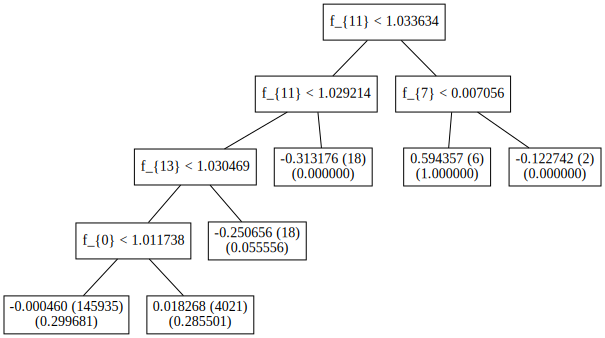

In [193]:
tree2gv(booster.forest[45][0])

In [194]:
dmat = xgb.DMatrix(features, label)

In [195]:
%%time
params = {'max_depth': 4, 'objective': 'binary:logistic', 'eta': 0.3, 'tree_method': 'exact', 'lambda': 1}
model = xgb.train(params, dmat, num_boost_round=50)

[22:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[22:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[22:24:09] /work

In [196]:
pred_fast = model.predict(dmat)
metrics.roc_auc_score(label[:, 0], pred_fast)

0.5987831226886691

In [197]:
pred_fast = model.predict(dmat, ntree_limit=35)
metrics.roc_auc_score(label[:, 0], pred_fast)

0.5859454632209743

In [198]:
pred2b = booster.predict(features, tree_limit=15)
metrics.roc_auc_score(label[:, 0], pred2b)

0.5689321897772331

In [199]:
dmat_test = xgb.DMatrix(f_test, l_test)

In [200]:
pred_test = model.predict(dmat_test)
metrics.roc_auc_score(l_test[:, 0], pred_test)

0.5457320402572653

In [64]:
qq = -np.log(1/pred_fast-1) 
np.min(qq), np.max(qq)

(-1.5864264, 0.065994635)

In [65]:
diff = np.abs(qq - pred2b)
np.mean(diff > 0.1)

0.05103666666666667

In [126]:
model.dump_model('xgb.dump')

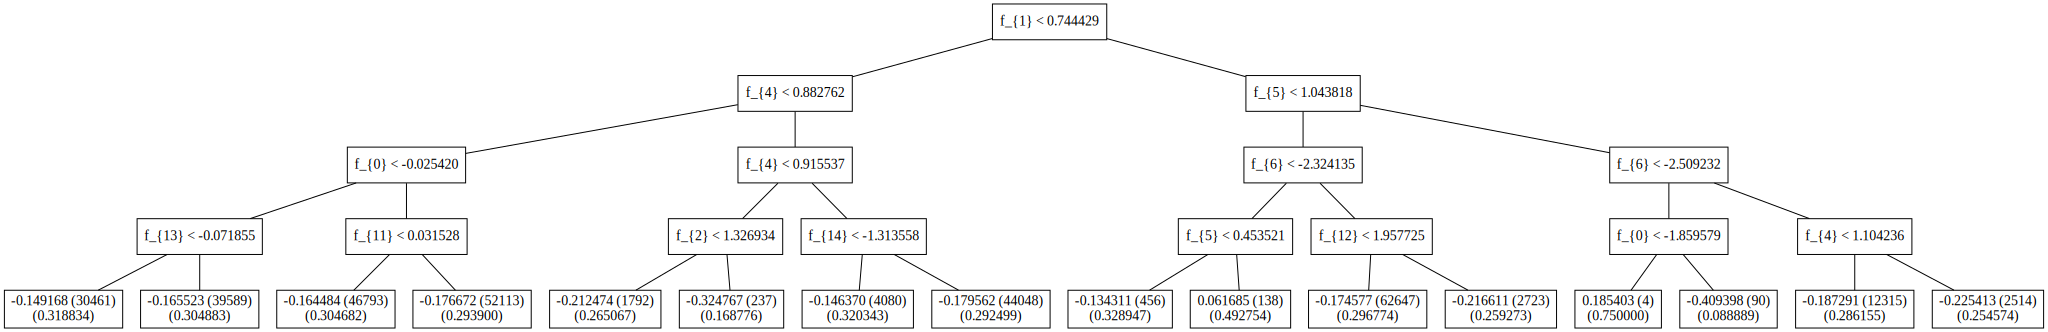

In [127]:
tree2gv(booster.forest[1][0])

In [129]:
!cat xgb.dump | tail -n+$(echo 39*31+31 | bc) | head -n 100

		3:[f14<-1.44106936] yes=7,no=8,missing=7
			7:[f4<-0.805379689] yes=15,no=16,missing=15
				15:leaf=-0.1056704
				16:leaf=0.366707087
			8:[f7<-0.2519961] yes=17,no=18,missing=17
				17:leaf=-0.202566758
				18:leaf=-0.0497117341
		4:[f12<-1.53471076] yes=9,no=10,missing=9
			9:[f12<-1.866346] yes=19,no=20,missing=19
				19:leaf=-0.105769083
				20:leaf=0.497406512
			10:[f14<1.75825262] yes=21,no=22,missing=21
				21:leaf=-0.0277387723
				22:leaf=0.261484325
	2:[f13<-2.58516383] yes=5,no=6,missing=5
		5:[f12<1.09795523] yes=11,no=12,missing=11
			11:[f14<0.833670616] yes=23,no=24,missing=23
				23:leaf=-0.066074118
				24:leaf=0.477993011
			12:leaf=0.587297797
		6:[f13<-2.5747304] yes=13,no=14,missing=13
			13:[f2<0.664820552] yes=25,no=26,missing=25
				25:leaf=-0.341729134
				26:leaf=0.0393396206
			14:[f13<-2.56904912] yes=27,no=28,missing=27
				27:leaf=0.195284322
				28:leaf=6.28011694e-05
booster[45]:
0:[f12<-3.94979334] yes=1,no=2,missing=1
	1:leaf=0.267755985
	2:[f12<-3